In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

# Import & Scale data

In [3]:
df_X = pd.read_csv('extract_train_Jul08.csv')
df_y = pd.read_csv('extract_label_Jul08.csv')

In [ ]:
df_X = df_X[df_X.columns[1:]]

In [5]:
scaler = StandardScaler()
scaler.fit(df_X)
X = pd.DataFrame(scaler.transform(df_X), columns=df_X.columns)
y = df_y['target']

In [6]:
X.head()

,index,mean,std,skew,FFT_mean_real,FFT_mean_imag,FFT_std_real,FFT_std_max,Roll_std_p05,Roll_std_p30,Roll_std_p60,Roll_std_absDiff,Roll_mean_p05,Roll_mean_absDiff,MFCC_mean02,MFCC_mean16
0,-1.731638,1.424262,-0.170139,-0.313682,1.199478,-0.816780,-0.104855,1.402387,0.138270,0.149755,0.077948,-0.125642,1.053724,-0.487263,-0.292342,0.996658
1,-1.730812,0.805767,0.004826,0.554010,0.078915,0.906173,-0.008441,0.794655,0.141994,0.146040,0.116614,-0.015114,0.697829,-0.137699,-0.409188,1.275636
2,-1.729986,1.511287,0.049349,0.191611,0.078915,0.245314,0.043961,1.487897,0.856458,0.642424,0.477151,0.121665,0.989016,1.078782,-0.408713,1.160981
3,-1.729161,1.495064,0.044046,1.321450,0.078915,-0.509953,0.044960,1.471957,0.375601,0.226170,0.212785,-0.205781,1.053724,-0.095752,-0.156636,0.581138
4,-1.728335,1.520375,0.088596,-0.128283,1.199478,-0.061513,0.078816,1.496827,0.319461,0.227556,0.144474,0.031985,1.215494,0.155934,0.040278,0.387829


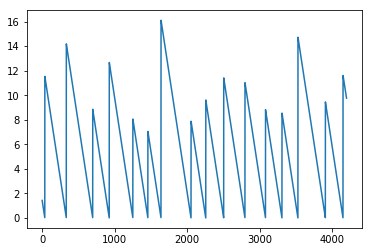

In [7]:
plt.plot(y); plt.show()

# PCA Feature Analysis

# Linear/Poly Regression

# Tree-based Model

In [8]:
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [9]:
def DecisionTree_classifier(X_train, y_train, X_val, y_val, X_test):
    model = DecisionTreeRegressor(min_samples_split = 25, random_state = 1, 
                                  criterion='mae',max_depth=5)
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return y_pred_val.flatten(), y_pred_test, model.feature_importances_

In [10]:
def RandomForest_classifier(X_train, y_train, X_val, y_val, X_test):
    model = RandomForestRegressor(max_depth=5,min_samples_split=9,random_state=0,
                                  n_estimators=50,criterion='mae')
    model.fit(X_train, y_train)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    return y_pred_val.flatten(), y_pred_test, model.feature_importances_

In [11]:
def lgbm_classifier(X_train, y_train, X_val, y_val, X_test):
    model = lgb.LGBMRegressor(num_leaves=54, min_data_in_leaf=79,objective= 'huber',
                              n_estimators = 20000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], 
              eval_metric='mae', verbose=False, early_stopping_rounds=200)

    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test, num_iteration=model.best_iteration_)
    
    return y_pred_val.flatten(), y_pred_test, model.feature_importances_

### K-Fold and Cross Validation

In [12]:
n_fold = 5
kfold = KFold(n_splits=n_fold, shuffle=True, random_state=1)

In [13]:
def K_fold_evaluation(X, y, X_test, func, classifier):
    y_pred_test_average, y_pred_train, scores = np.zeros(len(X_test)),np.zeros(len(y)), []
    feature_analysis = pd.DataFrame()
    
    print('%s classifier' %classifier)
    for ii, (train_idxes, val_indxes) in enumerate(kfold.split(X)):
        
        # Prepare the data
        X_train, X_val = X.iloc[train_idxes], X.iloc[val_indxes]
        y_train, y_val = y.iloc[train_idxes], y.iloc[val_indxes]
        
        # Fit the model and append score
        y_pred_val, y_pred_test, feature_importance = func(X_train, y_train, X_val, y_val, X_test)
        
        y_pred_train[val_indxes] = y_pred_val
        scores.append(mean_absolute_error(y_pred_val, y_val))
        y_pred_test_average += y_pred_test
        print('KFold %d: val_score = %.2f' %(ii+1, scores[-1]))
        
        current_feature_analysis = pd.DataFrame()
        current_feature_analysis['features'] = X.columns
        current_feature_analysis['importance'] = feature_importance
        feature_analysis = pd.concat([feature_analysis, current_feature_analysis], axis=0)
    
    y_pred_test_average = y_pred_test_average/n_fold
    feature_analysis['importance'] = feature_analysis['importance']/feature_analysis['importance'].max()
    print('-----------------------------------------------------------')
    print('Complete K-Fold and Cross Validation for %s' %(classifier))
    print('Validation MeanAbsoluteError: Mean = %.3f Std = %.3f' %(np.mean(scores), np.std(scores)))
    
    plt.figure(figsize=(18,6))
    plt.subplot(121); sns.barplot(x = 'importance', y = 'features', data= feature_analysis)
    plt.title('Feature Importance')
    plt.subplot(122);plt.title('KFold prediction on training set')
    plt.plot(y_pred_train, linewidth = 3); plt.plot(y, linewidth = 2); 
    plt.xlabel('Index'); plt.ylabel('Time before Failure (s)'); plt.legend(['Pred', 'Actual']);
    
    return scores, y_pred_train, y_pred_test_average,  feature_analysis

## Create a table for classifier and feature importance

In [14]:
classifier_table = pd.DataFrame()

def append_data(df,data, classifier):
    new_df = pd.DataFrame()
    new_df['MAE score'] = data
    new_df['Classifier'] = classifier
    return pd.concat([df, new_df], axis=0)

In [15]:
feature_table = pd.DataFrame()

def append_feature_analysis(feature_table, feature_analysis, classifier_name):
    df =feature_analysis.groupby(['features']).mean().sort_values(by = ['importance'],ascending=False)
    df = df/df['importance'].max()
    df = df.transpose()
    df.rename(index = {'importance': classifier_name}, inplace=True)
    df = pd.concat([feature_table, df], axis=0)
    var_names = sorted(df.columns)
    df = df[var_names].copy()
    return df

## Decision Tree Classifier

Decision Tree classifier
KFold 1: val_score = 2.12
KFold 2: val_score = 1.99
KFold 3: val_score = 2.10
KFold 4: val_score = 2.05
KFold 5: val_score = 2.07
-----------------------------------------------------------
Complete K-Fold and Cross Validation for Decision Tree
Validation MeanAbsoluteError: Mean = 2.067 Std = 0.044


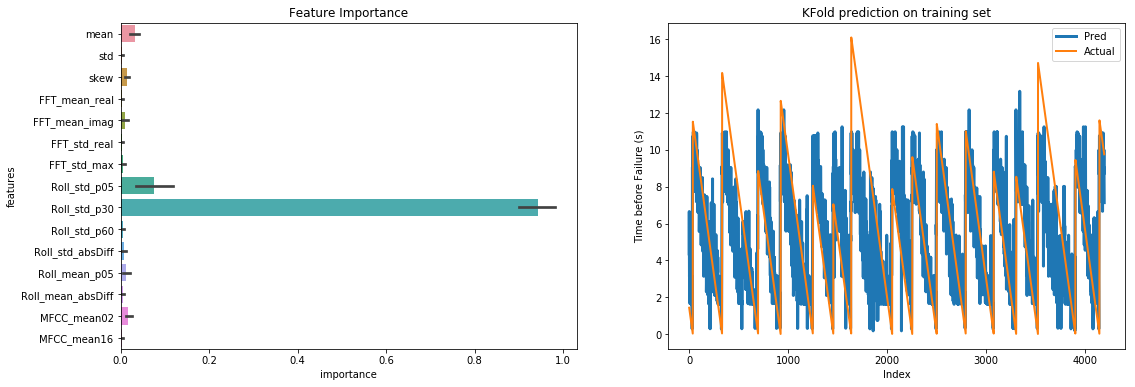

In [16]:
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                 DecisionTree_classifier,  'Decision Tree')
classifier_table =  append_data(classifier_table,scores, 'Decision Tree')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'Decision Tree')

# Random Forest Classifier

Random Forest classifier
KFold 1: val_score = 2.06
KFold 2: val_score = 1.97
KFold 3: val_score = 2.02
KFold 4: val_score = 2.03
KFold 5: val_score = 2.02
-----------------------------------------------------------
Complete K-Fold and Cross Validation for Random Forest
Validation MeanAbsoluteError: Mean = 2.020 Std = 0.031
Wall time: 1min 9s


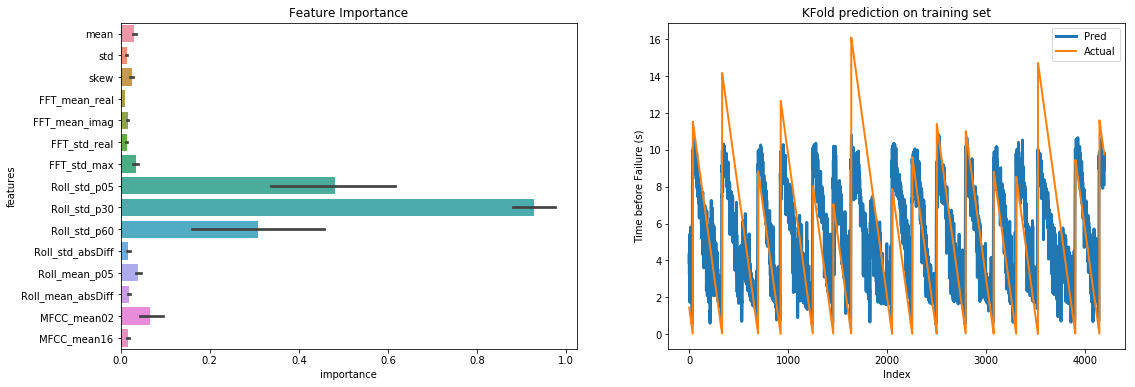

In [17]:
%%time
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                 RandomForest_classifier,  'Random Forest')
classifier_table =  append_data(classifier_table,scores, 'Random Forest')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'Random Forest')

### LGB Classifier

LGBM classifier
KFold 1: val_score = 2.06
KFold 2: val_score = 1.97
KFold 3: val_score = 2.02
KFold 4: val_score = 2.01
KFold 5: val_score = 2.05
-----------------------------------------------------------
Complete K-Fold and Cross Validation for LGBM
Validation MeanAbsoluteError: Mean = 2.024 Std = 0.033
Wall time: 3 s


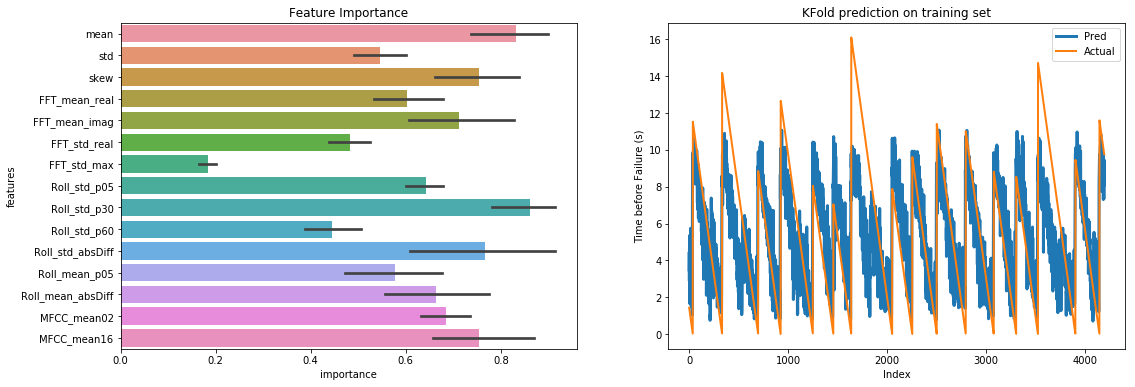

In [18]:
%%time
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X[X.columns[1:]], y, X[X.columns[1:]], 
                                                                                lgbm_classifier, 'LGBM')
classifier_table =  append_data(classifier_table,scores, 'LGBM')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'LGBM')

# Including the index (time) of the measurement

Decision Tree classifier
KFold 1: val_score = 1.81
KFold 2: val_score = 1.61
KFold 3: val_score = 1.80
KFold 4: val_score = 1.63
KFold 5: val_score = 1.73
-----------------------------------------------------------
Complete K-Fold and Cross Validation for Decision Tree
Validation MeanAbsoluteError: Mean = 1.717 Std = 0.083
Wall time: 3.78 s


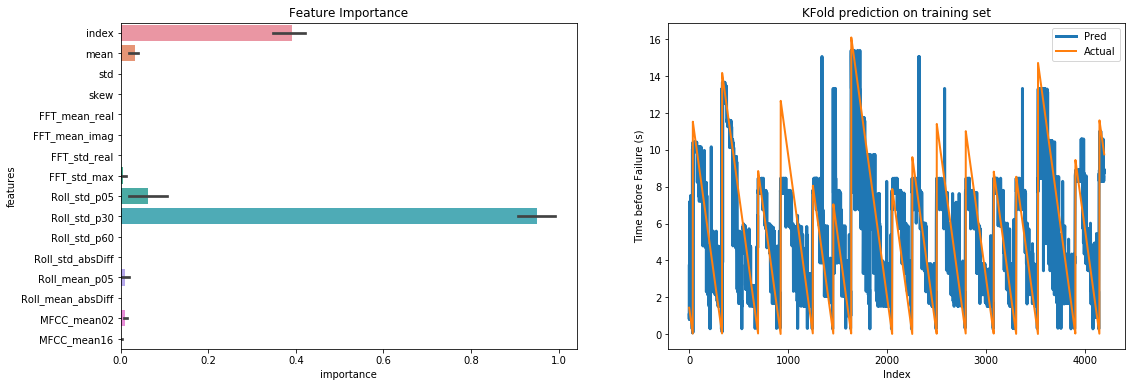

In [19]:
%%time
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X[X.columns[0:]], y, X[X.columns[0:]], 
                                                                 DecisionTree_classifier,  'Decision Tree')
classifier_table =  append_data(classifier_table,scores, 'DecisionTree (with index)')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'DecisionTree (with index)')

Random Forest classifier
KFold 1: val_score = 1.68
KFold 2: val_score = 1.57
KFold 3: val_score = 1.62
KFold 4: val_score = 1.60
KFold 5: val_score = 1.61
-----------------------------------------------------------
Complete K-Fold and Cross Validation for Random Forest
Validation MeanAbsoluteError: Mean = 1.617 Std = 0.038
Wall time: 1min 14s


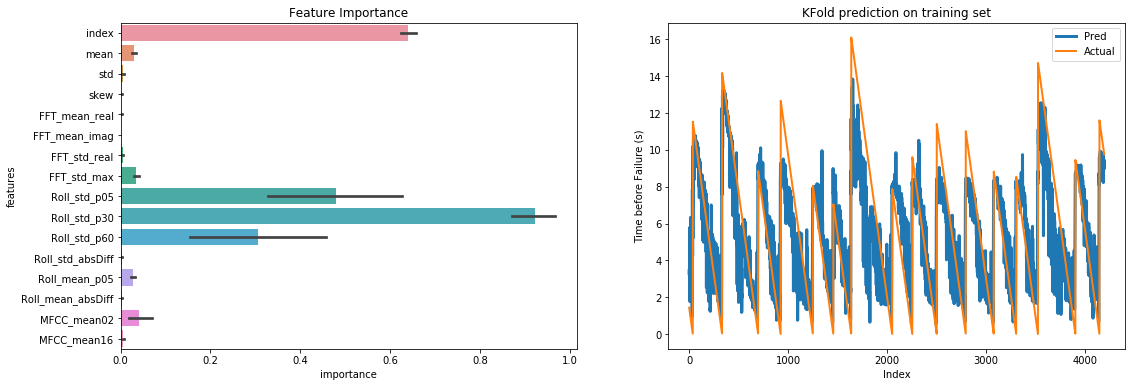

In [20]:
%%time
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X[X.columns[0:]], y, X[X.columns[0:]], 
                                                                 RandomForest_classifier,  'Random Forest')
classifier_table =  append_data(classifier_table,scores, 'Random Forest (with index)')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'Random Forest (with index)')

LGBM classifier
KFold 1: val_score = 0.70
KFold 2: val_score = 0.64
KFold 3: val_score = 0.74
KFold 4: val_score = 0.65
KFold 5: val_score = 0.68
-----------------------------------------------------------
Complete K-Fold and Cross Validation for LGBM
Validation MeanAbsoluteError: Mean = 0.680 Std = 0.036


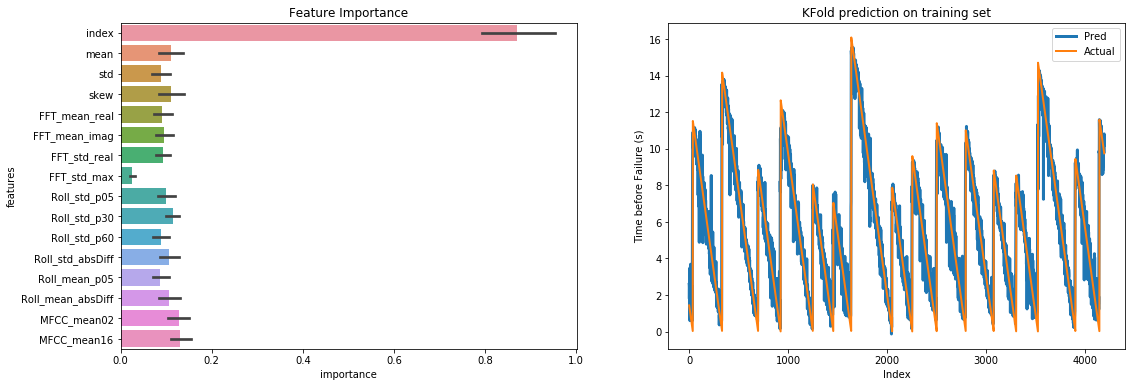

In [21]:
scores, y_pred_train, y_pred_test_average, feature_analysis = K_fold_evaluation(X, y, X, lgbm_classifier,'LGBM')
classifier_table =  append_data(classifier_table,scores, 'LGBM (with index)')
feature_table = append_feature_analysis(feature_table, feature_analysis, 'LGBM (with index)')

# Table of summary between various techniques

In [22]:
# add some dataframe to collect all the score and y_pred_test
# Think about it tmr

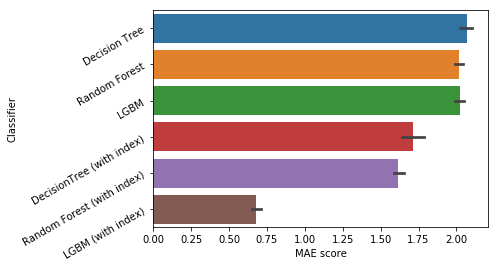

In [23]:
s = sns.barplot(y = classifier_table['Classifier'], x= classifier_table['MAE score'])
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=10);

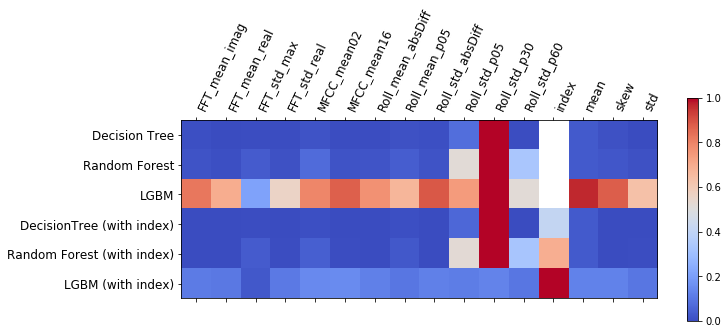

In [25]:
plt.matshow(feature_table.iloc[:,:],cmap=plt.cm.coolwarm)
plt.yticks(range(len(feature_table.index)), feature_table.index,fontsize=12)
plt.colorbar()
plt.xticks(range(len(feature_table.columns)),feature_table.columns,rotation=65,ha='left', fontsize=12)
#plt.tight_layout()
plt.show()#

In [26]:
classifier_table.to_csv('Tree_based_classifier_CV_MAE_Score.csv')
feature_table.to_csv('Tree_based_clasifier_feature_importance.csv')